In [1]:
import numpy as np
from pr3_utils import *
from stereo import *
from tqdm import tqdm

In [2]:
dataset = "10"

time_stamp,features,linear_velocity,angular_velocity,k,b,imu_T_cam = \
    load_data(f"../data/{dataset}.npz")

num_time_stamp = time_stamp.shape[0]
num_features = features.shape[1]

tau = time_stamp[1:] - time_stamp[:-1]
velocity = np.concatenate([linear_velocity, angular_velocity], axis=1)

T_mean = np.load(f"../data/predict_T_mean_{dataset}.npy")
T_covar = np.load(f"../data/predict_T_covar_{dataset}.npy")
M_init = np.load(f"../data/M_init_{dataset}.npy")

In [3]:
cam_T_imu = inversePose(imu_T_cam)
fsu = k[0,0]
fsv = k[1,1]
cu  = k[0,2]
cv  = k[1,2]
Ks = np.array([
    [fsu,0,cu,0],
    [0,fsv,cv,0],
    [fsu,0,cu,-fsu*b],
    [0,fsv,cv,0],
])
P = np.array([
    [1,0,0,0],
    [0,1,0,0],
    [0,0,1,0],
])

In [5]:
# noise model
V = 10

# log list
log_M_covar_norm_t = []
log_M_covar_norm = []

# init
M_mean = np.copy(M_init)
M_covar_flat = np.eye(3*num_features, 3*num_features, dtype=np.float16)
M_covar = M_covar_flat.reshape(num_features, 3, num_features, 3)

# EKF
for t in tqdm(range(1, num_time_stamp)):
    # update step
    present_mask = get_seeing_mask(features[t,:,:], d_min=3)
    Nt = np.sum(present_mask)
    
    # compose observation
    present_M_mean = M_mean[present_mask, :]
    present_M_mean_homo = np.hstack([present_M_mean, np.ones([Nt,1])])
    ixgrid = np.ix_(present_mask, np.arange(3), present_mask, np.arange(3))
    present_M_covar_flat = M_covar[ixgrid].reshape([Nt*3, Nt*3])

    # build H
    H = np.zeros([Nt, 4, Nt, 3])
    cam_T_world = cam_T_imu @ inversePose(T_mean[t])
    for j in range(Nt):
        # δh(T, m_j) / δm_j
        H[j,:,j,:] = Ks @ \
         projectionJacobian(cam_T_world @ present_M_mean_homo[j,:]) @ \
         cam_T_world@P.T
    H = H.reshape([Nt*4, Nt*3])

    # Kalman gain and innovation 
    K = present_M_covar_flat @ H.T @ np.linalg.inv(H @ present_M_covar_flat @ H.T + V*np.eye(Nt*4))
    innovation = K @ (
        features[t,present_mask,:] - (projection(present_M_mean_homo @ cam_T_world.T)@Ks.T)
    ).reshape(-1)
    
    # update
    M_mean[present_mask, :] = present_M_mean + innovation.reshape(-1, 3)
    M_covar[ixgrid] = (
        (np.eye(Nt*3) - K@H)@present_M_covar_flat
    ).reshape(Nt, 3, Nt, 3)

    # log covariance
    if t%50 == 0:
        log_M_covar_norm_t.append(time_stamp[t])
        log_M_covar_norm.append(np.linalg.norm(M_covar))

100%|██████████| 3025/3025 [00:36<00:00, 83.32it/s] 


[]

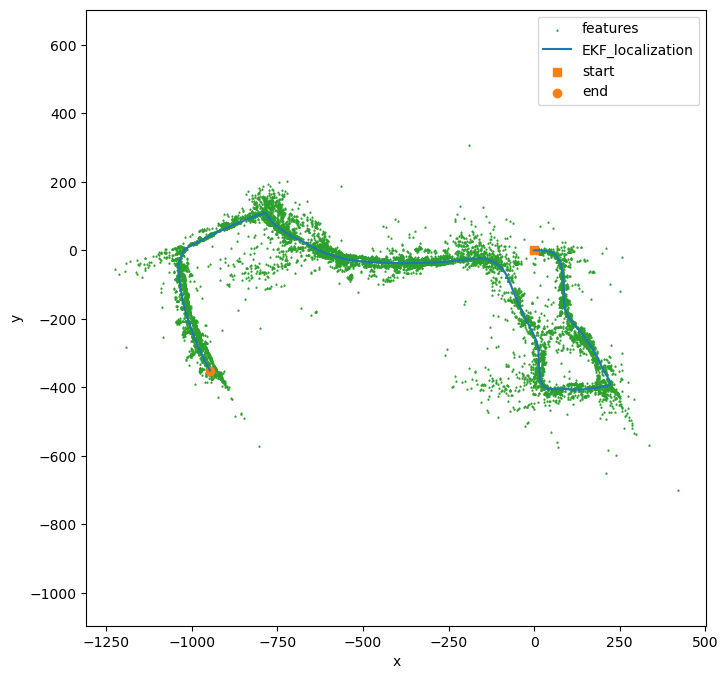

In [6]:
fig,_ = visualize_trajectory(T_mean, features=M_mean, show_ori=False, path_name="EKF_localization")
fig.savefig(f"../img/EKF_mapping_{dataset}", dpi=300)
plt.plot()

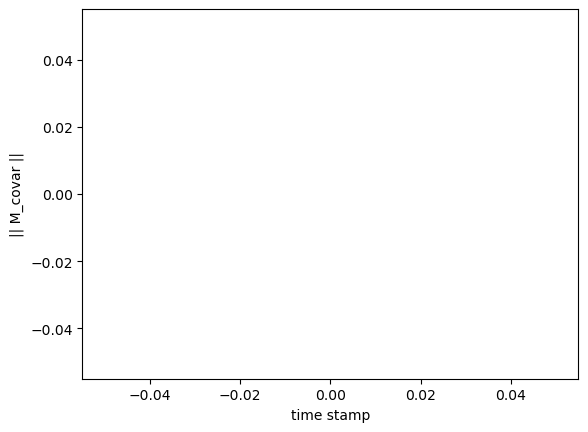

In [7]:
plt.plot(log_M_covar_norm_t, log_M_covar_norm)
plt.scatter(log_M_covar_norm_t, log_M_covar_norm)
plt.xlabel("time stamp")
plt.ylabel("|| M_covar ||")
plt.savefig(f"../img/M_covar_norm_{dataset}", dpi=300)
plt.show()

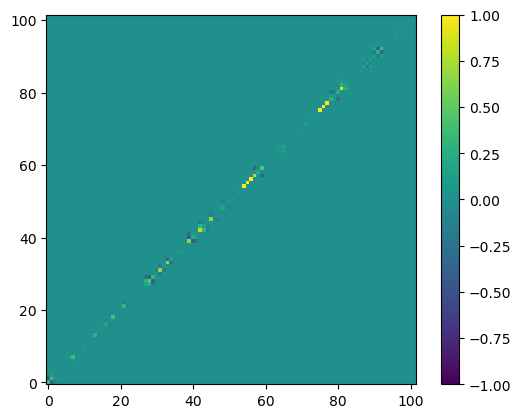

In [8]:
from matplotlib.colors import Normalize

sample_step = 400
size = int(np.ceil(num_features/sample_step)*3)
# vmin, vmax = np.min(M_covar), np.max(M_covar)
vmin, vmax = -1, 1
plt.imshow(
    M_covar[::sample_step, :, ::sample_step, :].reshape(size, size), 
    cmap='viridis', origin='lower', norm=Normalize(vmin=vmin, vmax=vmax))
plt.colorbar()
plt.savefig(f"../img/M_covar_sample_{dataset}", dpi=300)
plt.show()

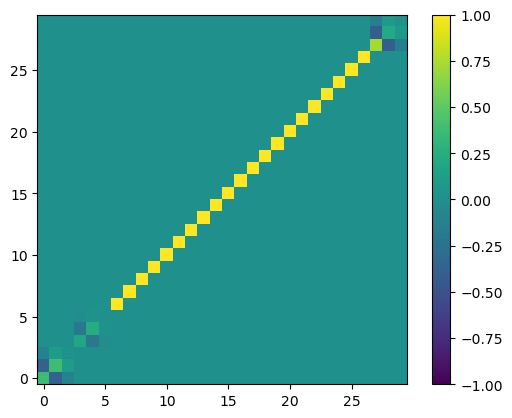

In [9]:
sample_step = 10
plt.imshow(
    M_covar[:sample_step, :, :sample_step, :].reshape(3*sample_step, 3*sample_step), 
    cmap='viridis', origin='lower', norm=Normalize(vmin=vmin, vmax=vmax))
plt.colorbar()
plt.savefig(f"../img/M_covar_{dataset}(first{sample_step}).png", dpi=300)
plt.show()

In [10]:
print(M_covar.nbytes/1024/1024/1024, "GB")

2.9604466427117586 GB


45130

### reshape trick

In [ ]:
import numpy as np
# f = np.arange(6).reshape(2,3)
# print(f, f.reshape(-1,1))
present_m = np.array([True, False, True])

cov = np.diag(np.arange(9)).reshape(3,3,3,3)
cov_full = cov.reshape(9,9)
print(cov_full)
cov[-2:,:,-2:,:].shape

In [ ]:
import numpy as np
h = np.arange(24)
j = h.reshape(4,6)

h, j

In [ ]:
h[0] = -1
j